# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

# Исследовательский анализ данных

## Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

## Загрузка и анализ данных

In [2]:
path = '/datasets/faces/'
df = pd.read_csv(path + 'labels.csv')

In [3]:
display(df.head())
display(df.info())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

Из данных мы видим, что он состоит из почти 7600 фотографий и колонки с возрастом.

In [4]:
image = Image.open('/datasets/faces/final_files/000003.jpg')
array = np.array(image)
array.shape

(370, 370, 3)

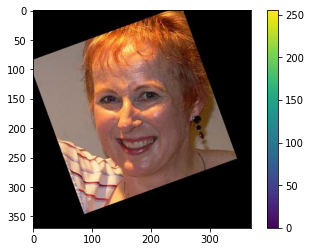

In [5]:
plt.imshow(array)
plt.colorbar();

Просмотрев несколько картинок мы видим, что возраст примерно соответсвует картинки.

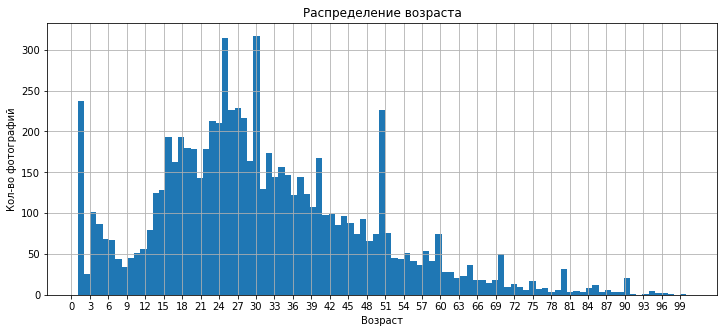

In [6]:
df['real_age'].hist(bins = len(df['real_age'].unique()),
                     figsize = (12,5))

plt.title('Распределение возраста')
plt.ylabel('Кол-во фотографий')
plt.xticks(range(0, df['real_age'].max(), 3))
plt.xlabel('Возраст')
plt.show()

In [7]:
df['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [8]:
df_old = df.loc[df['real_age'] > 91]
df_old.head()

,file_name,real_age
2661,002661.jpg,100
3260,003260.jpg,94
5776,005776.jpg,94
5806,005806.jpg,97
5809,005809.jpg,93


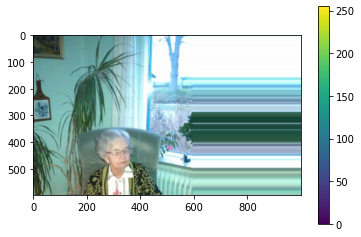

In [9]:
image = Image.open('/datasets/faces/final_files/002661.jpg')
array = np.array(image)
plt.imshow(array)
plt.colorbar();

In [10]:
df_young = df.loc[df['real_age'] < 3]
df_young.sort_values(by=['real_age']).head()

,file_name,real_age
7580,007602.jpg,1
7114,007129.jpg,1
2935,002935.jpg,1
3039,003039.jpg,1
3082,003082.jpg,1


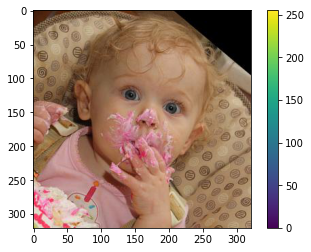

In [11]:
image = Image.open('/datasets/faces/final_files/000013.jpg')
array = np.array(image)
plt.imshow(array)
plt.colorbar();

Из гистограммы мы видим, что основная возрастная категория это люди от 20 до 41 года. Так же видим, что максимальный возраст является 100 лет, а минимальный 1 год. Количество фотографий людей старше 60 лет, значительно меньше, чем людей моложе 60.

In [12]:
datagen = ImageDataGenerator(validation_split=0.25, 
                             rescale = 1./255, 
                             horizontal_flip = True, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2)

train_datagen_flow = datagen.flow_from_dataframe(dataframe = df,
                                                 directory = path + 'final_files',
                                                 x_col='file_name',
                                                 y_col='real_age',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode='raw',
                                                 subset='training',
                                                 seed=12345)

val_datagen_flow = datagen.flow_from_dataframe(dataframe = df,
                                               directory = path + 'final_files',
                                               x_col='file_name',
                                               y_col='real_age',
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='raw',
                                               subset='validation',
                                               seed=12345)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


(32, 224, 224, 3)
[27 19 27  6 47 25 38 50 52  7 40 50 30 60  2 39 55 65 51 50 10 40  1 17
 30 35 61 25 48 37 43 90]


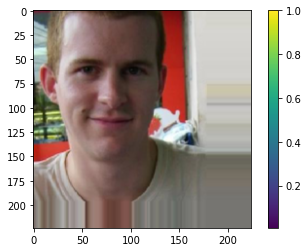

In [13]:
features, target = next(train_datagen_flow)
print(features.shape)
plt.imshow(features[0])
plt.colorbar();
print(target)

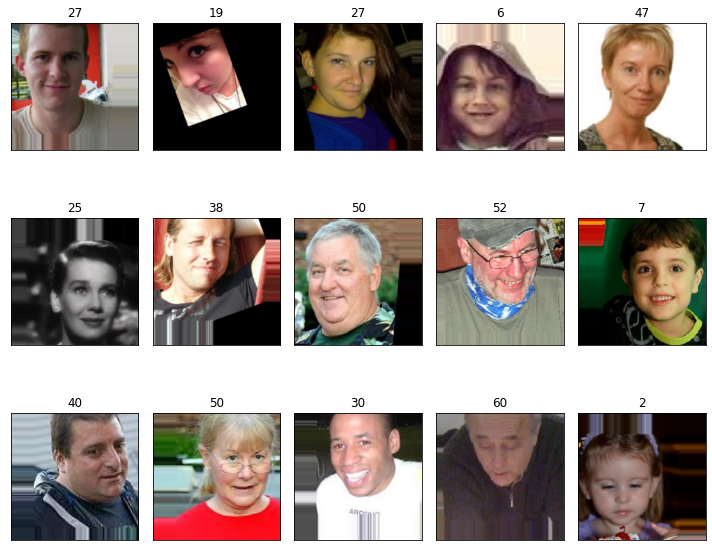

In [14]:
fig = plt.figure(figsize = (10,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Из фотографий мы видим, что в наборе фотографий проходила аугментация фотографий, как минимум фотографии поворачивали.

**Вывод**

Изучив данные, делаем вывод, что фотографии примерно корректно сопоставлены с возрастом. Преобладающее количество данных находится в промежутке возраста 20 до 41 года. Начиная с 60 летних людей, количество фотографий значительно сокращается по сравнению с остальными годами. Скорее всего с фотографиями проводили аугментацию, так как некоторые фотографии повернуты на несколько определенное количество градусов.

## Обучение модели

In [15]:
df = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(validation_split=0.25, 
                             rescale = 1./255, 
                             horizontal_flip = True, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2)

Делаем аугментацию фото. Делаем сдвиги и горизонтальный разворот, так как перед камерой человек может занять не четко центральное положение.

In [16]:
def load_train(path):
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe = df,
                                                     directory = '/datasets/faces/final_files/',
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224),
                                                     batch_size=32,
                                                     class_mode='raw',
                                                     subset='training',
                                                     seed=12345)
    
    
    return train_datagen_flow

In [17]:
test_datagen = ImageDataGenerator(validation_split=0.25, 
                             rescale = 1./255)

In [18]:
def load_test(path):
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe = df,
                                                     directory = '/datasets/faces/final_files/',
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224),
                                                     batch_size=32,
                                                     class_mode='raw',
                                                     subset='validation',
                                                     seed=12345)
    
    return test_datagen_flow

Создаем тренировочный сет и сет для теста.

In [19]:
def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])

    return model


In [20]:
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)    
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 

Задаем параметры обучения модели и обучаем модель. Архитектура модели была взята ResNet50. Так как данная модель наиболее подходит для нашей задачи.

## Результат модели

178/178 - 119s - loss: 11.1720 - mae: 11.1730 - val_loss: 22.8472 - val_mae: 22.8505
Epoch 2/5
178/178 - 116s - loss: 7.6556 - mae: 7.6551 - val_loss: 26.5925 - val_mae: 26.6075
Epoch 3/5
178/178 - 111s - loss: 6.8680 - mae: 6.8683 - val_loss: 12.9482 - val_mae: 12.9329
Epoch 4/5
178/178 - 110s - loss: 6.3074 - mae: 6.3078 - val_loss: 8.8875 - val_mae: 8.8692
Epoch 5/5
178/178 - 117s - loss: 5.9763 - mae: 5.9763 - val_loss: 6.8918 - val_mae: 6.8438
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 29s - loss: 6.7966 - mae: 6.8091
Test MAE: 6.8091

По заданию необходимо было добиться результата mae не менее 8. Наша модель показала менее 7. При увеличении эпох данный результат мог получится еще лучше, но потребовалось бы больше времени на обучение.

# Общий вывод

**В ходе исследования**

1. Загрузили данные, проверили их
2. Создали модель
3. Провели анализ


**Из исследования получены результаты:**

1. Изучив данные, мы пришли к выводу, что возрост из таблицы, указан правильно. Данные распределены не совсем равномерно. Преобладаю фотографии людей возраста менее 60 лет. Основной пул фотографий в возрасте от 20 до 41 года. Проверили правильно ли указан возраст на таких фотографиях с возрастом от 90 до 100 лет. Разделили данные на обучающую и тестовую выборку.
2. Выбор модели пал на ResNet50 так как данная модель показывает себя отлично на таких данных. Так как данных у нас достаточно при создании модели мы не использовали заморозку, и наша модель прошла полноценно по всем этапам. Модель мы проверяли на 5 эпохах. Этого хватило для достяжения необходимого результата. При увеличении количества эпох время обучения увеличилось, но и результат можно было получить более качественный. Так как у нас задача регрессии, и на выходе имеем один нейрон с множеством вариантов, активатор в модели использовался relu. При использовании функции потерь так же можно было использовать mse, что могло увеличить скорость работы модели, но так как скорость была удовлетворительная, то остановились на той жу функции, что и метрика. Так же в модели мы применили аугменацию, для того чтоб наша модель лучше работала, так как человек перед камерой не всегда стоит ровно в центре, для этого на тренировочной выборке, мы повернули некоторые фотографии.

**Общие рекомендации**

В данном проекте мы с запасом перешагнули необходимый результат mae. Для улучшения результата в датасет можно добавить больше фоторграфий людей возраста старше 60 лет, тогда наша модель научится лучше определять пожилых людей.